In [1]:
! pip install scikit-plot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from zipfile import ZipFile 

DATA = "feraligned+ck"
file_name = f"drive/My Drive/FER/datasets/{DATA}.zip"

with ZipFile(file_name, 'r') as zip_:
    print('Extracting all the files...') 
    zip_.extractall(DATA)
    print('Done!')

Extracting all the files...
Done!


In [0]:
import os
import cv2
import math
import joblib
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.2.0'

In [0]:
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/AdvancedNetworks/"
DATA_PATH = f"{DATA}/{DATA}/"
TOP_EMOTIONS = ["Happy", "Neutral", "Sadness"]

TRAIN_SIZE = 0.86
INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [7]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Happy has 2203 number of images
Neutral has 1230 number of images
Sadness has 1153 number of images

total images are 4586


In [8]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr.append(np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1,1))

img_arr.shape, img_label.shape, label_to_text

loaded Happy images to numpy arrays...
loaded Neutral images to numpy arrays...
loaded Sadness images to numpy arrays...


((4586, 48, 48, 1), (4586, 3), {0: 'Happy', 1: 'Neutral', 2: 'Sadness'})

In [0]:
img_arr = img_arr / 255.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3943, 48, 48, 1), (643, 48, 48, 1), (3943, 3), (643, 3))

In [0]:
def unit_block(X, filters: int, kernel_size: tuple, block_id: int):
    X_shortcut = X

    X = Conv2D(
        filters = filters,
        kernel_size = kernel_size,
        strides = (1,1),
        padding = 'same',
        name = f'block{block_id}_conv1',
        kernel_initializer = he_normal(seed=42),
    )(X)
    X = BatchNormalization(axis = 3, name = f'block{block_id}_bn1')(X)
    X = Activation('relu', name = f'block{block_id}_actv1')(X)

    X = Conv2D(
        filters = filters,
        kernel_size = kernel_size,
        strides = (1,1),
        padding = 'same',
        name = f'block{block_id}_conv2',
        kernel_initializer = he_normal(seed=42),
    )(X)
    X = BatchNormalization(axis = 3, name = f'block{block_id}_bn2')(X)
    X = Activation('relu', name=f'block{block_id}_actv2')(X)

    X = Add()([X, X_shortcut])

    return X

In [0]:
def CNN_with_SkipConnections(in_shape:tuple, out_shape:tuple, show_summary=False):
    model_in = Input(shape=in_shape, name="in_layer")

    # Block 1
    X = unit_block(model_in, filters=32, kernel_size=(3,3), block_id=1)
    X = Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = (2,2),
        padding = 'valid',
        name = 'block1_conv3',
        kernel_initializer = he_normal(seed=42),
    )(X)
    X = BatchNormalization(axis = 3, name = 'block1_bn3')(X)
    X = Activation('relu', name="block1_actv3")(X)

    # Block 2
    X = unit_block(X, filters=64, kernel_size=(3,3), block_id=2)
    X = Conv2D(
        filters = 128,
        kernel_size = (3,3),
        strides = (2,2),
        padding = 'valid',
        name = 'block2_conv3',
        kernel_initializer = he_normal(seed=42),
    )(X)
    X = BatchNormalization(axis = 3, name = 'block2_bn3')(X)
    X = Activation('relu', name="block2_actv3")(X)

    # Block 3
    X = unit_block(X, filters=128, kernel_size=(3,3), block_id=3)
    X = Conv2D(
        filters = 256,
        kernel_size = (3,3),
        strides = (2,2),
        padding = 'valid',
        name = 'block3_conv3',
        kernel_initializer = he_normal(seed=42),
    )(X)
    X = BatchNormalization(axis = 3, name = 'block3_bn3')(X)
    X = Activation('relu', name="block3_actv3")(X)

    #Block 4
    X = unit_block(X, filters=256, kernel_size=(3,3), block_id=4)
    # X = Conv2D(
    #     filters = 512,
    #     kernel_size = (3,3),
    #     strides = (2,2),
    #     padding = 'valid',
    #     name = 'block4_conv3',
    #     kernel_initializer = he_normal(seed=42),
    # )(X)
    # X = BatchNormalization(axis = 3, name = 'block4_bn3')(X)
    # X = Activation('relu', name="block4_actv3")(X)

    X = AveragePooling2D()(X)
    X = Flatten()(X)

    X = Dense(units=256, name="dense1")(X)
    X = BatchNormalization(name = 'dense1_bn')(X)
    X = Activation('relu', name="dense1_actv")(X)

    model_out = Dense(units=out_shape, activation="softmax", name="out_layer")(X)

    model = Model(inputs=model_in, outputs=model_out, name="CNN_with_SkipConnections")

    if show_summary:
        model.summary()
    
    return model

In [394]:
model = CNN_with_SkipConnections(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

Model: "CNN_with_SkipConnections"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_layer (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 48, 48, 32)   320         in_layer[0][0]                   
__________________________________________________________________________________________________
block1_bn1 (BatchNormalization) (None, 48, 48, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_actv1 (Activation)       (None, 48, 48, 32)   0           block1_bn1[0][0]                 
___________________________________________________________________________

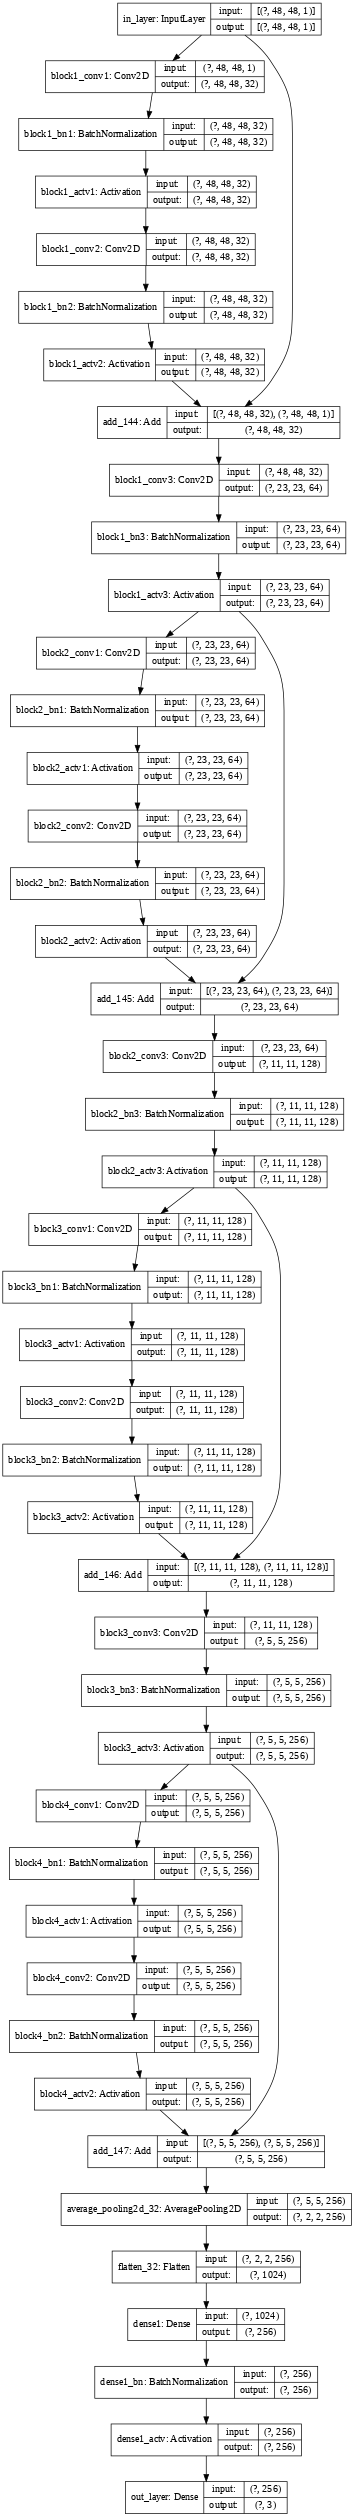

In [395]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50,)# to_file=BASE_PATH+'cnn.png')

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

In [0]:
BEST_CONFIG = {
    "batch_size": 32,
    "epochs": 75,
    "loss": "categorical_crossentropy",
    "optim": optimizers.Adam(0.001),
    "train_datagen": train_datagen,
    "callbacks": [lr_scheduler, early_stopping],
}

In [398]:
model.compile(
        loss=BEST_CONFIG["loss"],
        optimizer=BEST_CONFIG["optim"],
        metrics=['accuracy']
)

BEST_CONFIG["train_datagen"].fit(X_train)
history = model.fit(
    BEST_CONFIG["train_datagen"].flow(X_train, y_train, batch_size=BEST_CONFIG["batch_size"]),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / BEST_CONFIG["batch_size"],
    epochs=BEST_CONFIG["epochs"],
    callbacks=BEST_CONFIG["callbacks"],
)

Epoch 1/75
124/123 [==============================] - 6s 45ms/step - loss: 1.0318 - accuracy: 0.4966 - val_loss: 1.1641 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 2/75
124/123 [==============================] - 5s 42ms/step - loss: 0.8027 - accuracy: 0.6160 - val_loss: 0.9074 - val_accuracy: 0.5645 - lr: 0.0010
Epoch 3/75
124/123 [==============================] - 5s 42ms/step - loss: 0.7053 - accuracy: 0.6792 - val_loss: 0.6310 - val_accuracy: 0.6874 - lr: 0.0010
Epoch 4/75
124/123 [==============================] - 5s 42ms/step - loss: 0.6570 - accuracy: 0.6946 - val_loss: 0.5992 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 5/75
124/123 [==============================] - 5s 41ms/step - loss: 0.6265 - accuracy: 0.7177 - val_loss: 0.7088 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 6/75
124/123 [==============================] - 5s 42ms/step - loss: 0.5954 - accuracy: 0.7373 - val_loss: 0.5614 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 7/75
124/123 [==============================] - 5s 42ms/st

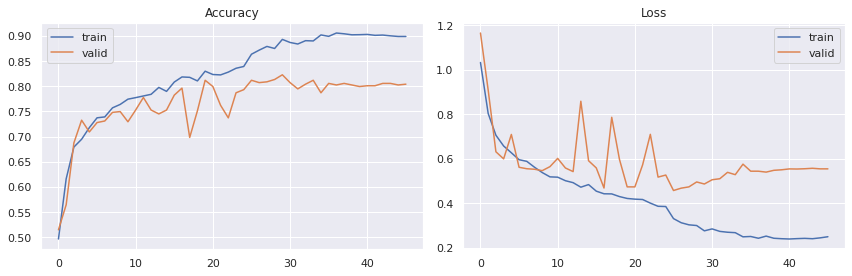

In [399]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

# pyplot.savefig(BASE_PATH+f'epoch_metrics/cnn_{DATA}_{NUM_CLASSES}emo.png')
pyplot.show()

In [400]:
label_to_text

{0: 'Happy', 1: 'Neutral', 2: 'Sadness'}

test accuracy: 82.2706 %


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       309
           1       0.66      0.81      0.73       172
           2       0.81      0.62      0.70       162

    accuracy                           0.82       643
   macro avg       0.80      0.79      0.79       643
weighted avg       0.83      0.82      0.82       643



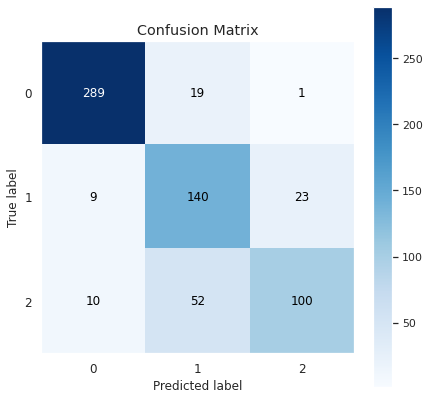

In [401]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
# pyplot.savefig(BASE_PATH+f"confusion_matrix/cnn_{DATA}_{NUM_CLASSES}emo.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [402]:
yhat_train = np.argmax(model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

train accuracy: 89.475 %
